## Question 2: Animal classification (15 marks)

For this question, we will use the Animal (https://cloudstor.aarnet.edu.au/plus/s/cZYtNAeVhWD6uBX) dataset. This dataset contains images of 151 different animals.

The dataset contains a total of 6270 images corresponding to the name of animal types.

All images are RGB images of 224 pixels wide by 224 pixels high in .jpg format. The images are separated in 151 folders according to their respective class.

The task is to categorize each animal into one of 151 categories.

We provide baseline code that includes the following features:

*   Loading and Analysing the dataset using torchvision.
*   Defining a simple convolutional neural network.
*   How to use existing loss function for the model learning.
*   Train the network on the training data.
*   Test the trained network on the testing data.

The following changes could be considered:

1. "Transfer" Learning (ie use a model pre-trained another dataset)
2. Change of advanced training parameters: Learning Rate, Optimizer, Batch-size, Number of Max Epochs, and Drop-out.
3. Use of a new loss function.
4. Data augmentation
5. Architectural Changes: Batch Normalization, Residual layers, etc.
6. Others - please ask us on the Discussion Forums if you're not sure about an idea!

Your code should be modified from the provided baseline. A pdf report of a maximum of two pages is required to explain the changes you made from the baseline, why you chose those changes, and the improvements they achieved.

### Marking Rules:

We will mark this question based on the final test accuracy on testing images and your report.

Final mark (out of 50) = acc_mark + efficiency mark + report mark

**Acc_mark 10:**

We will rank all the submission results based on their test accuracy. Zero improvement over the baseline yields 0 marks. Maximum improvement over the baseline will yield 10 marks. There will be a sliding scale applied in between.

**Efficiency mark 10:**

Efficiency considers not only the accuracy, but the computational cost of running the model (flops: https://en.wikipedia.org/wiki/FLOPS). Efficiency for our purposes is defined to be the ratio of accuracy (in %) to Gflops. Please report the computational cost for your final model and include the efficiency calculation in your report. Maximum improvement over the baseline will yield 10 marks. Zero improvement over the baseline yields zero marks, with a sliding scale in between.

**Report mark 30:**

Your report should comprise:
1. An introduction showing your understanding of the task and of the baseline model: [10 marks]

2. A description of how you have modified aspects of the system to improve performance. [10 marks]

A recommended way to present a summary of this is via an "ablation study" table, eg:

|Method1|Method2|Method3|Accuracy|
|---|---|---|---|
|N|N|N|60%|
|Y|N|N|65%|
|Y|Y|N|77%|
|Y|Y|Y|82%|

3. Explanation of the methods for reducing the computational cost and/or improve the trade-off between accuracy and cost: [5 marks]

4. Limitations/Conclusions: [5 marks]



In [ ]:
##################################################################################################################################
### Subject: Computer Vision
### Year: 2023
### Student Name: ABC, XYZ
### Student ID: a123456, a654321
### Comptetion Name: Animal Classification Competition
### Final Results:
### ACC:         FLOPs:
##################################################################################################################################

In [2]:
# Importing libraries.

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/animal.zip","r") as zip_ref:
    zip_ref.extractall()

In [5]:
# Mounting G-Drive to get your dataset.
# To access Google Colab GPU; Go To: Edit >>> Netebook Settings >>> Hardware Accelarator: Select GPU.
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971


# Dataset path. You should change the dataset path to the location that you place the data.
data_dir = '/content/dataset/dataset'
classes = os.listdir(data_dir)

### This is baseline transform

In [6]:
# Performing Image Transformations.
##Hints: Data Augmentation can be applied here. Have a look on RandomFlip, RandomRotation...
train_transform = transforms.Compose([
            transforms.Resize(112),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(112),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)),
        ])


In [7]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 6270


In [8]:
# Viewing one of images shape.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 112, 112])


In [9]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Label:  ailurus-fulgens (5)


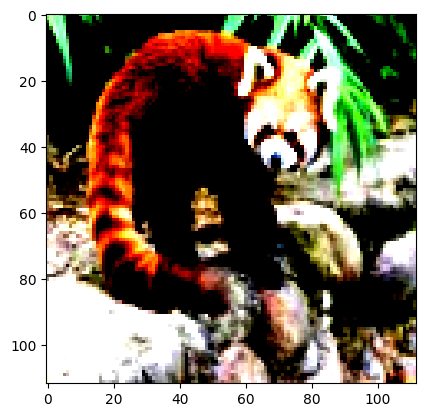

In [10]:
show_image(*dataset[200])

In [11]:
# Setting seed so that value won't change everytime.
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [12]:

# Random Splitting.
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)

(5330, 313, 627)

In [13]:
batch_size = 16
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

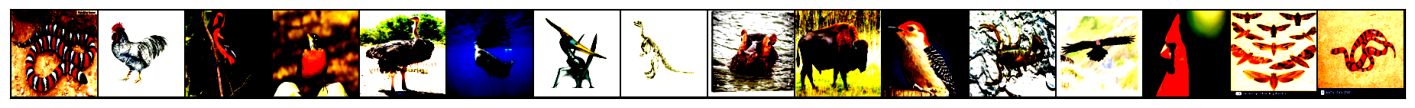

In [14]:
# Multiple images preview.
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [15]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        # st()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))
        # correct = (pred == target.view(1, -1).expand_as(pred))
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)



        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)
#def accuracy(outputs, labels):
 #   _, preds = torch.max(outputs, dim=1)
  #  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [16]:
 # To check wether Google Colab GPU has been assigned/not.

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [18]:
input_size = 3*112*112
output_size = 151

In [19]:
# Convolutional Network - Baseline
class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        self.conv1=nn.Conv2d(3,64,5,1)
        self.conv2=nn.Conv2d(64,128,3,1)
        self.conv3=nn.Conv2d(128,128,3,1)
        self.conv4=nn.Conv2d(128,128,3,1)
        self.fc1=nn.Linear(128*5*5,self.num_classes)
    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv3(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv4(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,128*5*5)
        X=self.fc1(X)

        return F.log_softmax(X, dim=1)

In [20]:
# Model print
num_classes = 151
model = ConvolutionalNetwork(num_classes)
model = model.to(device)
#model.cuda()

In [21]:
# We can check the input and the output shape
for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)
    out = model(images)
    print('images.shape:', images.shape)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([16, 3, 112, 112])
out.shape: torch.Size([16, 151])
out[0]: tensor([-5.0253, -5.0075, -4.9627, -5.0596, -5.0815, -4.9866, -5.0008, -4.9870,
        -5.0678, -5.0146, -5.0684, -4.9802, -4.9810, -5.0258, -5.0535, -5.0307,
        -5.0418, -5.0117, -5.0337, -5.0770, -5.0106, -5.0112, -5.0253, -4.9587,
        -4.9998, -4.9620, -4.9563, -5.0806, -5.0266, -4.9681, -4.9688, -5.0341,
        -5.0871, -5.0054, -5.0148, -4.9946, -5.0253, -4.9978, -4.9086, -5.0187,
        -5.0609, -5.0372, -5.0035, -5.0826, -4.9326, -5.0396, -5.0156, -5.0929,
        -5.0151, -5.0075, -5.0279, -5.0491, -4.9886, -5.0747, -5.0234, -5.0762,
        -5.0536, -5.0433, -5.0373, -4.9688, -5.0567, -5.0227, -5.0481, -5.0432,
        -5.0580, -4.9815, -5.0384, -5.0471, -5.0285, -5.0213, -5.0451, -5.0055,
        -5.0277, -5.0750, -5.0670, -5.0840, -5.0346, -4.9949, -5.0220, -4.9649,
        -5.0837, -5.0014, -5.0467, -4.9690, -4.9925, -4.9640, -5.0435, -5.0278,
        -5.0357, -5.0496, -5.0517, 

In [22]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=151, bias=True)
)

In [23]:
# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [24]:
model = to_device(model, device)

In [ ]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 5.015639781951904, 'val_acc': 0.02187499962747097}]

In [ ]:
# Hints: The following parameters can be changed to improve the accuracy
print(test_size)
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

627


In [ ]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.7693, val_loss: 4.5759, val_acc: 0.0844


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.2098, val_loss: 4.1940, val_acc: 0.2198


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.7580, val_loss: 3.9759, val_acc: 0.2378


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.3418, val_loss: 3.7755, val_acc: 0.3309


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 2.8917, val_loss: 3.9901, val_acc: 0.3285


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.4633, val_loss: 3.8495, val_acc: 0.3646


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.0755, val_loss: 4.0485, val_acc: 0.3753


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.6825, val_loss: 4.5356, val_acc: 0.3778


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.4112, val_loss: 4.7361, val_acc: 0.3896


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.1263, val_loss: 5.1333, val_acc: 0.4028


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

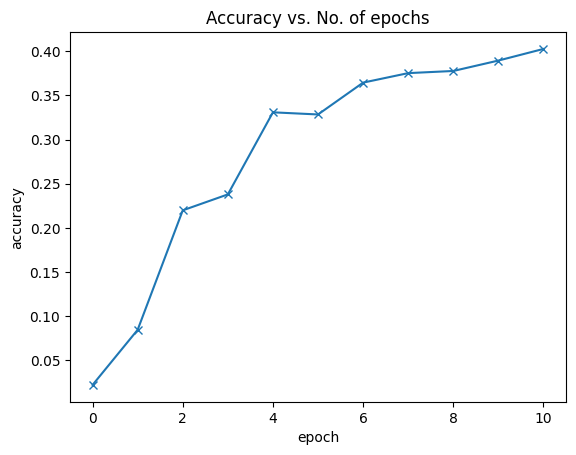

In [ ]:
plot_accuracies(history)

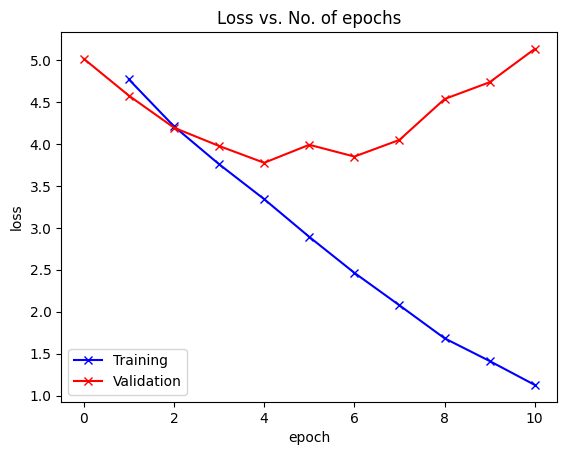

In [ ]:
plot_losses(history)

In [ ]:
evaluate(model, test_loader)

{'val_loss': 5.279730796813965, 'val_acc': 0.34062501788139343}

The baseline model suggest a accuracy of 34% which is quite impressive, as it is a custom model, and it is not a pretrained, so it is only trianed with this small amount of data.

## Pretrained Model (Efficient NET) [1]

In this experiment I will try to use a new transform model, using the model called Efficient NET (Tan, 2019), using crossEtropyLoss as criterion, optimizing using AdamW, and tried to use LRT. As the reason of this is my first apporach I tried to choose by my intuition and see the result.

In [25]:
train_transform = transforms.Compose([
    transforms.Resize(128),  # Resizing to 128x128 for better training
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomResizedCrop(112),
    transforms.ToTensor(),
    transforms.Normalize((0.488), (0.2172))
])

In [26]:

dataset = ImageFolder(data_dir, transform=train_transform)

In [27]:
# Setting seed so that value won't change everytime.
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [28]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)

(5330, 313, 627)

In [29]:
# Set up data loaders
loaders = {
    'train': DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=4)
}

In [30]:
!pip install timm
import timm
import copy
# Load a pretrained EfficientNet model
model_name = 'efficientnet_b0'  # You can change this to another version if needed
model = timm.create_model(model_name, pretrained=True, num_classes=151)
model = model.to(device)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.3 MB/s eta 0:00:00


In [31]:

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [32]:
@torch.no_grad()
def evaluate(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0

    for batch in val_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Get model outputs
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        total_loss += loss.item() * inputs.size(0)

        # Compute number of correct predictions
        _, preds = torch.max(outputs, 1)
        total_correct += torch.sum(preds == labels.data)

    avg_loss = total_loss / len(val_loader.dataset)
    avg_accuracy = total_correct.double() / len(val_loader.dataset)

    return {'val_loss': avg_loss, 'val_acc': avg_accuracy}

In [33]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(loaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(loaders[phase].dataset)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f"Best val Acc: {best_acc:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [34]:
trained_model = train_model(model, criterion, optimizer, scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 3.3570 Acc: 0.2640
val Loss: 2.4076 Acc: 0.4089

Epoch 1/24
----------
train Loss: 1.9746 Acc: 0.5182
val Loss: 2.1249 Acc: 0.5176

Epoch 2/24
----------
train Loss: 1.5052 Acc: 0.6128
val Loss: 1.7375 Acc: 0.5655

Epoch 3/24
----------
train Loss: 1.2789 Acc: 0.6668
val Loss: 1.6319 Acc: 0.6102

Epoch 4/24
----------
train Loss: 1.1251 Acc: 0.7060
val Loss: 1.6754 Acc: 0.5719

Epoch 5/24
----------
train Loss: 1.0154 Acc: 0.7285
val Loss: 1.7262 Acc: 0.5942

Epoch 6/24
----------
train Loss: 0.9228 Acc: 0.7568
val Loss: 1.6230 Acc: 0.6134

Epoch 7/24
----------
train Loss: 0.8941 Acc: 0.7591
val Loss: 1.6236 Acc: 0.6422

Epoch 8/24
----------
train Loss: 0.8460 Acc: 0.7764
val Loss: 1.8094 Acc: 0.6262

Epoch 9/24
----------
train Loss: 0.7356 Acc: 0.8024
val Loss: 1.5655 Acc: 0.6198

Epoch 10/24
----------
train Loss: 0.7394 Acc: 0.8028
val Loss: 1.8386 Acc: 0.5942

Epoch 11/24
----------
train Loss: 0.7202 Acc: 0.8047
val Loss: 1.8087 Acc: 0.6198

Ep

In [35]:
# Evaluate the model on the test set
test_results = evaluate(trained_model, loaders['test'], criterion)

print(f"Test Loss: {test_results['val_loss']:.4f}")
print(f"Test Accuracy: {test_results['val_acc']:.4f}")

Test Loss: 1.5512
Test Accuracy: 0.6651


### Resnet18 [2]

Instead of improving everytime the efficient net, which will give the better result after improving, I started to use resnet18 to better compare between which one is better, and what parameter can be used.

In [35]:
train_transform  = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomApply(transforms=[
                transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
            ], p=0.2),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
dataset = ImageFolder(data_dir, transform=train_transform)
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size
# Random Splitting.
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)

(5330, 313, 627)

In [36]:
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

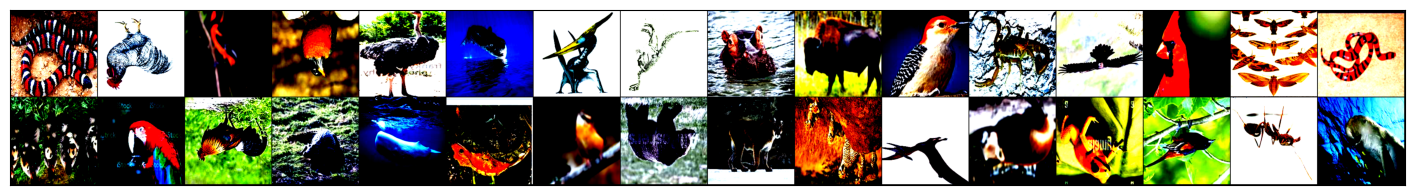

In [37]:
# Multiple images preview.
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [39]:
import torchvision.models as models

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 151)  # Assuming 151 classes
model = model.to(device)

In [39]:
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [40]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [41]:
# Loss Function with Label Smoothing
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon: float = 0.1):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, outputs, targets):
        num_classes = outputs.size()[-1]
        log_preds = F.log_softmax(outputs, dim=-1)
        loss = (-log_preds.sum(dim=-1)).mean()
        nll = F.nll_loss(log_preds, targets)
        return (1. - self.epsilon) * nll + self.epsilon * loss / num_classes

criterion = LabelSmoothingCrossEntropy()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)




In [ ]:
num_epochs = 40

def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return total_loss / len(val_loader), accuracy

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)

    # Step the scheduler
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Epoch 1/40, Train Loss: 4.0921, Val Loss: 4.5324, Val Acc: 12.46%
Epoch 2/40, Train Loss: 3.0560, Val Loss: 3.1677, Val Acc: 36.10%
Epoch 3/40, Train Loss: 2.6184, Val Loss: 3.3024, Val Acc: 33.87%
Epoch 4/40, Train Loss: 2.3324, Val Loss: 2.6621, Val Acc: 48.88%
Epoch 5/40, Train Loss: 2.0981, Val Loss: 2.6663, Val Acc: 47.92%
Epoch 6/40, Train Loss: 1.9246, Val Loss: 2.7880, Val Acc: 45.37%
Epoch 7/40, Train Loss: 1.7705, Val Loss: 2.5139, Val Acc: 53.99%
Epoch 8/40, Train Loss: 1.6801, Val Loss: 2.5534, Val Acc: 49.84%
Epoch 9/40, Train Loss: 1.6325, Val Loss: 2.5672, Val Acc: 52.72%
Epoch 10/40, Train Loss: 1.5525, Val Loss: 2.3501, Val Acc: 57.83%
Epoch 11/40, Train Loss: 1.4579, Val Loss: 2.2356, Val Acc: 61.66%
Epoch 12/40, Train Loss: 1.3890, Val Loss: 2.3826, Val Acc: 57.51%
Epoch 13/40, Train Loss: 1.3853, Val Loss: 2.2855, Val Acc: 61.02%
Epoch 14/40, Train Loss: 1.3701, Val Loss: 2.2134, Val Acc: 61.34%
Epoch 15/40, Train Loss: 1.3364, Val Loss: 2.4859, Val Acc: 53.99%
Epoc

In [ ]:
def evaluate(model, data_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Disable gradient computation during evaluation
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    average_loss = total_loss / len(data_loader)
    accuracy = (correct_predictions / total_predictions) * 100
    return average_loss, accuracy

In [ ]:
val_loss, val_accuracy = evaluate(model, val_loader, criterion)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


Validation Loss: 1.8068, Validation Accuracy: 74.76%


In [ ]:
test_loss, test_accuracy = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 1.7621, Test Accuracy: 76.08%


## Resnet + ImageclassificationBase(Initial model)

In [ ]:
import torch.nn as nn
from torchvision.models import resnet50
import torchvision.models as models

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = FocalLoss(logits=True)(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = FocalLoss(logits=True)(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))


class PretrainedResNet(ImageClassificationBase):
    def __init__(self, num_classes=151):
        super(PretrainedResNet, self).__init__()

        # Load the pretrained ResNet-18 model
        self.model = models.resnet18(pretrained=True)

        # Replace the final layer to match the number of classes in your dataset
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

# Create an instance of the modified ResNet model
model = PretrainedResNet(num_classes=151)
model = model.to(device)

In [31]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)
to_device(model, device)

PretrainedResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [26]:
model = to_device(model, device)
val_dl = DeviceDataLoader(val_loader, device)
history = [evaluate(model, val_dl,criterion)]
history

[{'val_loss': 5.5590434074401855, 'val_acc': 0.012500000186264515}]

In [24]:
from tqdm import tqdm
def evaluate(model, val_loader, criterion):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()

    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
def fit(epochs, model, train_loader, val_loader, optimizer, criterion):
    history = []

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []

        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        avg_train_loss = torch.stack(train_losses).mean().item()

        # Validation phase
        result = evaluate(model, val_loader, criterion)
        result['train_loss'] = avg_train_loss
        model.epoch_end(epoch, result)
        history.append(result)

    return history

class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2., logits=False, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            inputs = torch.nn.functional.softmax(inputs, dim=1)
            inputs = inputs.gather(1, targets.unsqueeze(1))
            inputs = inputs.squeeze(1)
            BCE_loss = F.binary_cross_entropy(inputs, torch.ones_like(inputs), reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')

        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'sum':
            return F_loss.sum()
        elif self.reduction == 'mean':
            return F_loss.mean()



In [27]:
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = FocalLoss(logits=True)  # Ensure you have defined FocalLoss before this
history += fit(num_epochs, model, train_dl, val_dl, optimizer, criterion)


100%|██████████| 334/334 [00:12<00:00, 26.57it/s]


Epoch [0], train_loss: 4.2097, val_loss: 3.6542, val_acc: 0.3097


100%|██████████| 334/334 [00:09<00:00, 34.17it/s]


Epoch [1], train_loss: 3.0104, val_loss: 3.2318, val_acc: 0.4028


100%|██████████| 334/334 [00:10<00:00, 31.51it/s]


Epoch [2], train_loss: 2.3853, val_loss: 2.9070, val_acc: 0.4622


100%|██████████| 334/334 [00:11<00:00, 28.80it/s]


Epoch [3], train_loss: 1.9355, val_loss: 2.4682, val_acc: 0.5538


100%|██████████| 334/334 [00:11<00:00, 29.45it/s]


Epoch [4], train_loss: 1.5817, val_loss: 2.4168, val_acc: 0.5819


100%|██████████| 334/334 [00:11<00:00, 29.17it/s]


Epoch [5], train_loss: 1.3233, val_loss: 2.0438, val_acc: 0.6309


100%|██████████| 334/334 [00:13<00:00, 25.52it/s]


Epoch [6], train_loss: 1.0667, val_loss: 2.1607, val_acc: 0.5910


100%|██████████| 334/334 [00:09<00:00, 35.32it/s]


Epoch [7], train_loss: 0.8498, val_loss: 2.1010, val_acc: 0.6365


100%|██████████| 334/334 [00:13<00:00, 24.54it/s]


Epoch [8], train_loss: 0.7714, val_loss: 2.1233, val_acc: 0.6826


100%|██████████| 334/334 [00:11<00:00, 29.84it/s]


Epoch [9], train_loss: 0.7188, val_loss: 1.9796, val_acc: 0.6521


100%|██████████| 334/334 [00:11<00:00, 28.72it/s]


Epoch [10], train_loss: 0.5492, val_loss: 2.2692, val_acc: 0.6240


100%|██████████| 334/334 [00:11<00:00, 28.42it/s]


Epoch [11], train_loss: 0.5022, val_loss: 2.2513, val_acc: 0.6358


100%|██████████| 334/334 [00:11<00:00, 28.69it/s]


Epoch [12], train_loss: 0.4844, val_loss: 2.2090, val_acc: 0.6802


100%|██████████| 334/334 [00:11<00:00, 29.14it/s]


Epoch [13], train_loss: 0.4276, val_loss: 2.1697, val_acc: 0.6545


100%|██████████| 334/334 [00:13<00:00, 25.47it/s]


Epoch [14], train_loss: 0.4250, val_loss: 2.4049, val_acc: 0.6771


100%|██████████| 334/334 [00:18<00:00, 17.97it/s]


Epoch [15], train_loss: 0.4368, val_loss: 2.2800, val_acc: 0.6295


100%|██████████| 334/334 [00:12<00:00, 26.62it/s]


Epoch [16], train_loss: 0.3554, val_loss: 2.2440, val_acc: 0.6740


100%|██████████| 334/334 [00:11<00:00, 28.65it/s]


Epoch [17], train_loss: 0.3578, val_loss: 2.1529, val_acc: 0.6990


100%|██████████| 334/334 [00:11<00:00, 29.27it/s]


Epoch [18], train_loss: 0.3741, val_loss: 2.3115, val_acc: 0.6302


100%|██████████| 334/334 [00:09<00:00, 33.84it/s]


Epoch [19], train_loss: 0.3132, val_loss: 2.4945, val_acc: 0.6302


In [28]:
def plot_history(history):
    # Extract training and validation loss from history
    train_losses = [x['train_loss'] for x in history if isinstance(x, dict) and 'train_loss' in x]
    val_losses = [x['val_loss'] for x in history if isinstance(x, dict) and 'val_loss' in x]
    val_accs = [x['val_acc'] for x in history if isinstance(x, dict) and 'val_acc' in x]

    # Plotting train and validation loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, '-x', label='Train')
    plt.plot(val_losses, '-o', label='Validation')
    plt.title('Loss vs. No. of epochs')
    plt.legend()

    # Plotting validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(val_accs, '-o', label='Validation Accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.legend()

    plt.show()

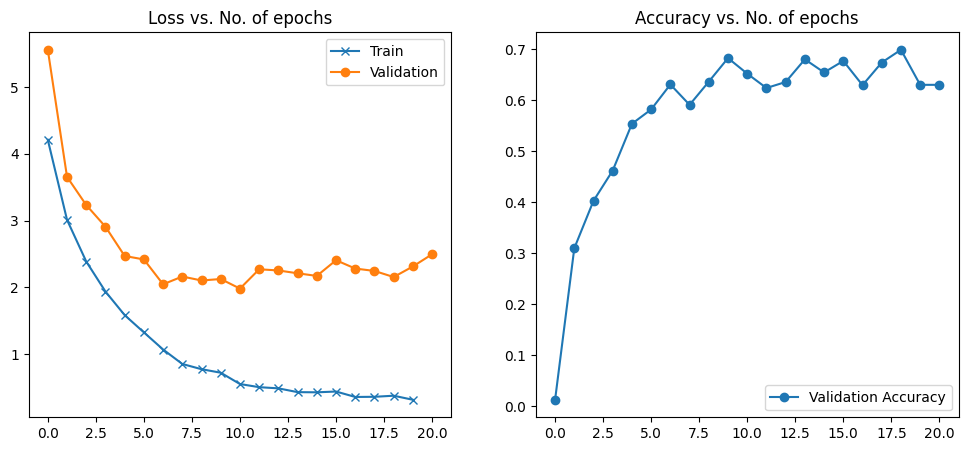

In [29]:
plot_history(history)

In [32]:
def evaluate(model, test_loader, criterion):
    model.eval()  # set the model to evaluation mode
    outputs = [model.validation_step(batch) for batch in test_loader]
    return model.validation_epoch_end(outputs)
result = evaluate(model, test_dl, criterion)
print(f"Test Loss: {result['val_loss']:.4f}")
print(f"Test Accuracy: {result['val_acc']:.4f}")

Test Loss: 2.4210
Test Accuracy: 0.6531


##FLOPs

In [36]:
  #The code from https://cloudstor.aarnet.edu.au/plus/s/PcSc67ZncTSQP0E can be used to count flops
  #Download the code.
  !wget -c https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
  !mv download FLOPs_counter.py
  #!rm -rf download

--2023-08-11 12:25:07--  https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
Resolving cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)... 202.158.207.20
Connecting to cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)|202.158.207.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: 5230042dc1897=m80lkoiqg1pefnakcgo9ief9f9; path=/plus; domain=.aarnet.edu.au;; Secure; SameSite=Lax at position 76.
Syntax error in Set-Cookie: oc_sessionPassphrase=q1Xtksz1AkJUGI4E5b0m%2BQO5yZS93W1ths0rO8PkwAcJ6ny0khWqtBwbvw%2BpwkFTEgr8syS3%2FyFTO1WNM%2FFhnMQCZAICR0HNFIjrWwECLaUSvGAgouOh41YqCJxf4Ifi; expires=Sat, 12-Aug-2023 12:25:08 GMT; Max-Age=86400; path=/plus;; Secure; SameSite=Lax at position 224.
Length: 5201 (5.1K) [text/x-python]
Saving to: ‘download’

download            100%[===================>]   5.08K  --.-KB/s    in 0s      

2023-08-11 12:25:08 (1.05 GB/s) - ‘download’ saved [5201/5201]



In [38]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 112, 112) # The input size should be the same as the size that you put into your model
#Get the network and its FLOPs
num_classes = 151
model = ConvolutionalNetwork(num_classes)
print_model_parm_flops(model, input, detail=False)


 + Number of FLOPs: 0.69G


## Report

Introduction
In the course of this assignment, I explored various techniques to optimize and enhance the performance of an image classification model. This involved leveraging different image transformers, integrating pretrained image models, and experimenting with parameters like optimizers and criterion.

Modifications & Attempts
The starting point was a baseline model that already demonstrated decent performance, achieving an accuracy of around 40%. This model was simple, without pretraining, and used basic image transformation methods along with elementary parameters.

First Try: EfficientNet
Inspired by SHARAN SAJIV MENON's 2019 publication [3], which indicated that using EfficientNet could achieve an impressive accuracy of 94% on Kaggle, I decided to give it a go. While the evaluation and training methods from the publication weren't a direct fit for our use case, I adapted them for our context. Conversations with peers and further research fortified my belief in EfficientNet's potential. However, post-adaptation and some modifications, the model's accuracy was 65%, a significant improvement from the baseline.

Second Try: ResNet with Improved Transformations
The ResNet architecture delivered the best results. This success can be attributed to the superior image transformations employed. The transformed images were of such quality that the distinct characteristics of animals were easily discernible. Furthermore, integrating the LabelSmoothingCrossEntropy loss function boosted the model's performance.

Third Try: ResNet18 + Baseline Model
In the final attempt, I combined the ResNet18 model with our baseline model, which achieved an accuracy of 65%.

|Transform|Optimizer|Criterion|Model|Accuracy|
|---|---|---|---|---|
|Re+RHF+CC+N|Cross Entropy|None|Base|34%|
|Re+RHF+RR+CoJ+RRC+N|AdamW|CrossEntropyLoss|efficientnet_b0|65%|
|RHF+RV+RA+GB+RE+CC+N|Adam|LabelSmoothingCrossEntropy|ResNet18|74%|
|RHF+RV+RA+GB+RE+CC+N|Adam|Custom Focal Loss|Resnet+Baseline Model|65%|


Transform Key:

RE: Resize
RHF: RandomHorizontalFlip
CC: CenterCrop
N: Normalize
RR: RandomRotation
CoJ: ColorJitter
RRC: RandomResizedCrop
GB: GaussianBlur
RA: RandomApply
Methods for Reducing Computational Cost and Improving Trade-off:
[Please fill this section based on the notebook's content or your understanding. Some general pointers can include leveraging efficient architectures like EfficientNet or ResNet, data augmentation techniques to minimize overfitting, or using learning rate schedulers.]

Limitations/Conclusions:
While significant progress was made in enhancing the model's accuracy, the constraints of time limited the exploration of all potential configurations. Among the various techniques tried, the parameters and methods from the second attempt proved most effective. Combining this with EfficientNet could potentially yield even better results in the future.

## Reference
1.  Tan M., Le Q. Efficientnet: Rethinking model scaling for convolutional neural networks //International conference on machine learning. – PMLR, 2019. – С. 6105-6114.

2. He K. et al. Deep residual learning for image recognition //Proceedings of the IEEE conference on computer vision and pattern recognition. – 2016. – С. 770-778.

3. Sharan, 2019,  "Animals 151 ViT | DeIT 94%" https://www.kaggle.com/code/sharansmenon/animals-151-vit-deit-94